In [1]:
import torch

import onnxruntime as ort

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Export Torch -> ONNX

In [2]:
file_size = os.path.getsize('models/face_det.pt')
print("File Size is :", round(file_size/1024**2, 2), "mb")

File Size is : 5.93 mb


In [4]:
model = torch.load('models/face_det.pt')['model']
model.eval()
model.float()
model = model.fuse()

inputs = torch.randn(1, 3, 640, 640)
classes = model.names

torch.onnx.export(model,
                  inputs,
                  "models/face_det.onnx",
                  verbose=False,
                  opset_version=14,
                  do_constant_folding=True,
                  input_names = ['images'],
                  output_names = ['output0'])

Model summary (fused): 168 layers, 3005843 parameters, 0 gradients


In [5]:
file_size = os.path.getsize('models/face_det.onnx')
print("File Size is :", round(file_size/1024**2, 2), "mb")

File Size is : 11.52 mb


In [6]:
# from ultralytics import YOLO

# model = YOLO('models/face_det.pt')
# model.export(format='onnx')

## Inference ONNX model

In [7]:
# read model

model_path = "models/face_det.onnx"
session = ort.SessionOptions()
session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider','CUDAExecutionProvider'])
input_name = session.get_inputs()[0].name
output_names = [i.name for i in session.get_outputs()]
in_w, in_h = session.get_inputs()[0].shape[2:]

classes = torch.load('models/face_det.pt')['model'].names

In [8]:
# Non-Maximum Suppression with data processing

def nms(data):
    data = data[0][0].T
    data = data[np.max(data[:, 4:], axis=1) > 0.3]
    
    boxes = data[:,:4]
    scores = np.max(data[:, 4:], axis=1)
    cls_idx = np.argmax(data[:, 4:], axis=1)
    
    boxes /= np.array([in_w, in_h, in_w, in_h])
    boxes *= np.array([im_w, im_h, im_w, im_h])

    boxes[:, 0] = boxes[:, 0] - boxes[:, 2]/2
    boxes[:, 1] = boxes[:, 1] - boxes[:, 3]/2
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.3)[0]
        order = order[inds + 1]
        
    return boxes[keep], scores[keep], cls_idx[keep]

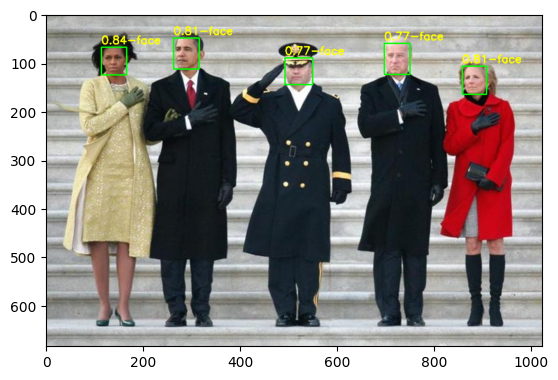

In [9]:
# image predict

image_path = 'images/test.jpg'
real_img = cv2.imread(image_path)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
im_h,im_w = real_img.shape[:2]
image = cv2.resize(real_img, (in_w,in_h))
image = image.transpose(2,0,1) / 255.
image = image[np.newaxis, :, :, :].astype('float32')

output_data = session.run(output_names, {input_name: image})
boxes, scores, cls_idx = nms(output_data)

thresh = 0.5
for (box, score, idx) in zip(boxes, scores, cls_idx):
    if score > thresh:
        
        box = np.round(box).astype(np.int32).tolist()
        score = round(float(score), 2)

        cv2.rectangle(real_img, box[:2], box[2:], (0,255,0), 2)
        cv2.putText(real_img, str(score)+'-'+classes[idx], (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 0], thickness=2)
            
plt.imshow(real_img)
plt.show()

In [10]:
cap = cv2.VideoCapture("images/test.mp4")

if (cap.isOpened()== False):
    print("Error opening video file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        real_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_h,im_w = real_img.shape[:2]
        image = cv2.resize(real_img, (in_w,in_h))
        image = image.transpose(2,0,1) / 255.
        image = image[np.newaxis, :, :, :].astype('float32')

        output_data = session.run(output_names, {input_name: image})
        boxes, scores, cls_idx = nms(output_data)

        thresh = 0.3
        for (box, score, idx) in zip(boxes, scores, cls_idx):
            if score > thresh:

                box = np.round(box).astype(np.int32).tolist()
                score = round(float(score), 2)

                cv2.rectangle(frame, box[:2], box[2:], (0,255,0), 2)
                cv2.putText(frame, str(score)+'-'+classes[idx], (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)
        
        cv2.imshow('Frame', frame)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()